# Using Python and Monte Carlo to Simulate Student Finance Amortization

## TL;DR - Quick Abstract
I became frustrated with the numbers not adding up on my Student Loan statements and speculative opinions about never paying it off and getting the loan cancelled. I wanted to gauge my likelihood of paying off the full loan and simulated my earnings using Monte Carlo and another method. I used Python to implement it - code walk through below.

## Intro

In the last year, I have developed a keen interest in personal finance and utilising automation to improve the handling and growth of personal finances (triggered by Ramit Sethi's amazing [book](https://www.amazon.co.uk/Will-Teach-You-Rich-Second/dp/1523505745/ref=tmm_pap_swatch_0?_encoding=UTF8&qid=&sr=) and [blog](https://www.iwillteachyoutoberich.com/), which I highly recommend). I became interested in my Student Loan and my lifetime repayment (amortization) of it. 

In the UK, students can take out university loans for both tuition fees and living costs ("maintenance loans") with [Student Finance England](https://www.gov.uk/student-finance), who provide loans underwritten by the Student Loans Company who act on behalf of the government. Once you leave university and enter employment you then begin to pay off your loan on a monthly schedule, as part of your tax deductions. Crucially, if you do not pay off your loan, plus interest, in 30 years, your loan is cancelled.

## Rationale

There are several reasons I became so interested in and, frankly, frustratingly intrigued by this project:
* The **main reason**: the more reading I did into the loans, the more I realised how murky and dense a lot of the documentation is surrounding repayment - even analysing my statements from the Student Loans Company for the interest accrued in a given period didn't make sense when I ran the numbers - it's confusing, and no-one online or in my circle could give me clear answers
* Conflicting opinions surrounding paying off the loan - everything from "it comes out of my tax so I don't even notice it", to "most students won't pay it off and it will get cancelled, so paying upfront might be wasting your money" - but "most students" refers only to averages, with huge variance in earnings (and therefore amortization) between subjects, universtiy attended and industry
* Graduates today in the UK, leave university with a staggering sum of debt - I wanted to cut through the noise and understand exactly how the loans work as part of my research and **quantify my probability of paying it off**

Now, working in Data Science, and trained at university as a scientist, nothing annoys me more than the concept of not needing to understand something, or learning something superficially. I left university with a total of £42,000 in debt, and so the notion of blindly paying a huge debt and not knowing how it works really frustrated me. 

## Questions
Here are the questions I wanted to answer:
1. How likely am I, and other graduates, to pay off our student loans inside of the 30 year payment window, following university courses?
2. If you manage to save money, or come across a sum of money (e.g. inheritance), should you put it towards your loan in the form of voluntary payments?

## Facts
* Students taking out loans since 2012 are on "Plan 2" loans
* You only start paying these back when you earn more than £2,214 a month or £26,568 a year (pre-tax)
* You are due to start repaying the April after graduating (or the April 4 years after starting - whichever comes first) - i.e. if you enter employment immediately after graduating, you won't start repying on your payslips until the following April
* You begin acruing interest from the day of your first loan (i.e. shortly after arriving at university)
* Interest acrues daily
* [Plan 2 loans are written off](https://www.gov.uk/repaying-your-student-loan/when-your-student-loan-gets-written-off-or-cancelled) 30 years after the April you were first due to repay

## Student Loans are not like other loans, they're more of a tax
* Regular loans from the bank are drawn up with a fixed interest rate and regular payments (e.g. monthly) which are independent of your salary
* The amount you pay back to your Student Loan is determined by how much you earn, so it behaves much more like a tax
* In this way, people who earn more contribute more, paying for the loans of graduates who earn less
* Interest rates are variable, not fixed - they are calculated as inflation plus 3%, so rates have been as high as x% in recent years

## Method
* Build a simulator in python which runs through 30 years of payments towards the loan, with the loan simultanously accruing interest daily
* Simulate across many different salary trajectories, using Monte Carlo (more below)

# Import Python Libraries

In [3]:
import os
import pandas as pd
import numpy as np

# Working with datetime objects
from datetime import date, timedelta
from pandas.tseries.offsets import BMonthEnd

# Scraping interest rates off the web
import requests
from bs4 import BeautifulSoup

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Build Functions
Read in my student finance statements for all loan instalments and interest payments throughout my degree

In [4]:
def readPayments(file_name, date_header="PaymentDate"):
    '''Reads in student finance statement'''
    dataLoc = os.path.join(current_wd, "..", "data", file_name)
    paymentsData = pd.read_csv(dataLoc, index_col=date_header, parse_dates=True)
#     paymentsData[date_header] = pd.to_datetime(paymentsData[date_header])
    
    return paymentsData

In [5]:
# Read in my statement detailing university instalments
current_wd = os.getcwd()
file_name = "trimmed_data.csv"
myPayments = readPayments(file_name)
myPayments.head()

,Instalment,Gross
PaymentDate,,
2014-09-25,1,1191.3
2014-10-15,1,2250.0
2015-01-05,2,1191.3
2015-02-04,2,2250.0
2015-04-20,3,1227.4


Some basic functions for calculating tax (based on UK [tax bands](https://www.gov.uk/income-tax-rates)), [national insurance contribution (NIC)](https://www.gov.uk/national-insurance/how-much-you-pay) and [student finance payments](https://www.gov.uk/repaying-your-student-loan/what-you-pay) based on your gross salary (pre-tax).

In [6]:
def calcTaxPA(grossSalaryPA):
    '''calculates tax paid per year based on 
    UK tax bands'''
    taxFreeAllowance = 12500
    if grossSalaryPA <= taxFreeAllowance:
        taxPA = 0
    elif grossSalaryPA <= 50000:
        taxPA = 0.2*(grossSalaryPA - 12500)
    elif grossSalaryPA > 50000 and grossSalaryPA <= 150000:
        taxPA = (0.4*(grossSalaryPA - 50000)) + (0.2*(50000 - 12500))
    elif grossSalaryPA > 150000:
        taxPA = (0.45*(grossSalaryPA - 150000)) + (0.4*(150000 - 50000)) + (0.2*(50000 - 12500))
    return taxPA


def calcNICPA(grossSalaryPA):
    '''calculates national insurance contribution per year
    based on UK bands'''
    grossSalaryPW = grossSalaryPA/52
    if grossSalaryPW >= 962:
        NICPW = 0.02*(grossSalaryPW-962) + 0.12*(962-166)
    elif grossSalaryPW > 166:
        NICPW = 0.12*(grossSalaryPW - 166)
    else:
        NICPW = 0
    return NICPW*52


def calcStudentFinPM(grossSalaryPA):
    '''calculates student finance per year'''
    grossSalaryPM = grossSalaryPA/12
    thresholdPM = 2143
    if grossSalaryPM > thresholdPM:
        StudentFinPM = 0.09*(grossSalaryPM-thresholdPM)
    else:
        StudentFinPM = 0
    return StudentFinPM


def calcNetSalary(grossSalaryPA):
    '''calculates net salary after tax and all other deductions'''
    netSalaryPA = grossSalaryPA - calcTaxPA(grossSalaryPA) - calcNICPA(grossSalaryPA) - calcStudentFinPA(grossSalaryPA)
    return netSalaryPA

At certain points in my simulation, my salary increases by a random amount drawn from a gaussian distriubtion - the parameters of which are iterated over. This simulates career progression - changing to a job with a higher salary or receiving a payrise.

In [7]:
def salaryIncrease(grossSalaryPA, mean, sd):
    '''increase salary my random amount drawn from gaussian distribution'''
    increaseStep = np.random.normal(mean, sd)
    return grossSalaryPA+increaseStep

To calculate how much I owed at the end of university, I need to calculate the interest that is applied to a given instalment, which changes at the start each academic year (September 1st). The first part was to get these rates from the [government website](https://www.gov.uk/guidance/how-interest-is-calculated-plan-2), using a simple web scraper (```BeautifulSoup```) which takes the interest rates for different academic years from the government website and stores them in a dictionary. The second part was to build a function which could take any date during my degree and find the interest rate at that point in time.

In [8]:
## Web scrape historic interest rates

url = 'https://www.gov.uk/guidance/how-interest-is-calculated-plan-2'
headers = {'User-Agent': 'Mozilla/5.0'}
page = requests.get(url, headers=headers)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find('table')
table_rows = results.find_all('tr')

# Store interest rates in dictionary of academic years
historicInterest = {}
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    if len(row) > 0:
        row[0] = row[0].split('to')
        row[0][0] = pd.Timestamp(row[0][0])
        row[0][1] = pd.Timestamp(row[0][1])
        year = str(row[0][0].year)
        historicInterest.setdefault(year, 0)
        historicInterest[year] = {}
        historicInterest[year].setdefault("start", 0)
        historicInterest[year]["start"] = row[0][0].date()
        historicInterest[year].setdefault("end", 0)
        historicInterest[year]["end"] = row[0][1].date()
        historicInterest[year].setdefault("rate", 0)
        historicInterest[year]["rate"] = float(row[1][:-1])/100

def findInterestRate(paymentDate):
    '''Finds interest rate of loan for a given date'''
    try:
        year = paymentDate.year
        sdate = historicInterest[str(year)]["start"]
        edate = historicInterest[str(year)]["end"]
        delta = edate - sdate
    
        allDates = [sdate + timedelta(days=i) for i in range(delta.days+1)] # create list of all dates in date range sdate to edate

        if paymentDate in allDates:
            rate = historicInterest[str(year)]["rate"]
        else:
            rate = historicInterest[str(year-1)]["rate"]
    except KeyError: # key error will occur for dates in years that have no published interest rate as they don't appear in dictionary
        rate = historicInterest[str(year-1)]["rate"]
    return rate

To calculate how much I owed after university I need to simulate each passing day's interest (whilst studying) and also add in the instalments arriving from Student Finance England. You can either simulate up to the end of graduation year (August 31st), or up to the start of employment (when you begin paying back the loan), using the ```simEnd``` argument. NB: in my case I was not employed until after the April following graduation, so did not need to build in the rule for this.

In [9]:
def graduateAmount(simEnd, employmentStart, myPayments=None): # simEnd argument ends simulation either on the last payment in data, at the end of graduation academic year or at commencement of employment
    '''calculate total student debt owed in graduation year or manually input total'''
    cumulativeTotal = 0
    interestRate = 0
    if myPayments is not None:
        startDate = myPayments.index.min()
        if simEnd == "yearEnd":
            graduationYear = myPayments.index.max().year # assumes that final payment occurs during graduation year
            yearEnd = str(graduationYear)+"-08-31"
            endDate = pd.Timestamp(yearEnd) # simulation ends at end of academic year of final payment
        elif simEnd == "employment":
            endDate = pd.Timestamp(employmentStart)
        else:
            endDate = myPayments.index.max() # simulation ends at final payment

        delta = timedelta(days=1)
        
        while startDate <= endDate: # up to and including final payment
            interestRate = findInterestRate(startDate)
            cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
            if startDate in myPayments.index:
                cumulativeTotal += myPayments.loc[startDate]["Gross"]
            startDate += delta                
            
    else:
        print("Please enter your net total of Student Debt at graduation")
        cumulativeTotal = input()
    return cumulativeTotal

In [10]:
def loanAtEmployment(principal, principal_date, employment_start):
    '''when payment data is absent, plug in last statement amount and date'''
    endDate = pd.Timestamp(employment_start)
    startDate = principal_date
    cumulativeTotal = principal
    delta = timedelta(days=1)
    
    while startDate <= endDate: # up to and including final payment
        interestRate = findInterestRate(startDate)
        cumulativeTotal *= (1+(interestRate/365)) # apply interest on previous payments before new payment
        startDate += delta
    return cumulativeTotal

### The Main Function!
Using the above functions, the value owed in Student Finance at the start of employment can be calculated. From this point onwards, you begin paying back towards your loan in the style of a tax. In this simulation, interest accrues on the loan daily, and on the last working day of the month (```BMonthEnd()```), your repayment comes out of your salary (details in intro), as in reality. 

In [11]:
def simulateLifetimeEarnings(grossSalaryPA, N, principal, employment_start, method="monte carlo", increases=None):
    '''Simulates payment of student debt across career based on monthly tax payments according to
    estimate salary and compounding interest of loan'''
    salary = []
    salary.append(grossSalaryPA)
    
    today = pd.Timestamp(employment_start)
    start = today
    edate = today + timedelta(days=N*365)
    delta = timedelta(days=1)
    offset = BMonthEnd()
    
    cumulativeTotal = principal
    cumulativeList = []
    cumulativeList.append(cumulativeTotal)
    while today <= edate:
        if method == "monte carlo" and increases is not None:
            if ((today - start).days/365)%5 == 0 and (today - start).days > 0:
#                 print((today - start).days/365/5)
                grossSalaryPA *= increases[(today - start).days/365/5]
                
        elif method == "monte carlo" and increases is None:
            print("Please supply monte carlo simulated salary increases")
            
        if method == "median":
            if (today - start).days%365 == 0 and (today - start).days/365 in male_HE.index:
                grossSalaryPA = male_HE.loc[(today - start).days/365]['Earning']

        cumulativeTotal *= (1+(0.05/365)) # apply interest on previous payments before new payment
        
        if today == offset.rollforward(today) and today.month == offset.rollforward(today).month: # if today in sim is last working day
            cumulativeTotal -= calcStudentFinPM(grossSalaryPA)
            cumulativeList.append(cumulativeTotal)
            salary.append(grossSalaryPA)
            
        today += delta

    return cumulativeList, salary

## Simulating Median Graduate Earnings
To try out the simulator, I began by using higher education salary data from an incredibly thorough new report [*The impact of undergraduate degree on lifetime earnings*](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/869263/The_impact_of_undergraduate_degrees_on_lifetime_earnings_research_report_ifs_dfe.pdf). I can run the simulation for median male and female graduate earnings. The code used here is mostly plotting, which I will skip for space.

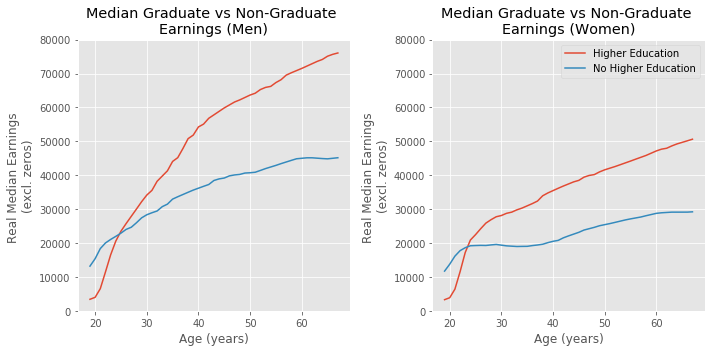

In [13]:
male_HE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_men_HE.csv"),header=None, names = ['Age', 'Earning'])
male_HE['Age'] = male_HE['Age'].round()
male_HE = male_HE.groupby(by='Age').mean()

male_noHE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_men_nonHE.csv"), header=None, names = ['Age','Earning'])
male_noHE['Age'] = male_noHE['Age'].round()
male_noHE = male_noHE.groupby(by='Age').mean()

female_HE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_women_HE.csv"),header=None, names = ['Age', 'Earning'])
female_HE['Age'] = female_HE['Age'].round()
female_HE = female_HE.groupby(by='Age').mean()

female_noHE = pd.read_csv(os.path.join(current_wd, "..", "data", "real_median_women_nonHE.csv"), header=None, names = ['Age','Earning'])
female_noHE['Age'] = female_noHE['Age'].round()
female_noHE = female_noHE.groupby(by='Age').mean()



fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
axes[0].plot(male_HE.index, male_HE['Earning'], label = "Higher Education")
axes[0].plot(male_noHE.index, male_noHE['Earning'], label = "No Higher Education")
axes[0].set_xlabel("Age (years)")
axes[0].set_ylabel("Real Median Earnings \n(excl. zeros)")
axes[0].set_ylim([0,80000])
axes[0].title.set_text('Median Graduate vs Non-Graduate \nEarnings (Men)')
axes[1].plot(female_HE.index, female_HE['Earning'], label = "Higher Education")
axes[1].plot(female_noHE.index, female_noHE['Earning'], label = "No Higher Education")
axes[1].set_xlabel("Age (years)")
axes[1].set_ylabel("Real Median Earnings \n(excl. zeros)")
axes[1].set_ylim([0,80000])
axes[1].title.set_text('Median Graduate vs Non-Graduate \nEarnings (Women)')
plt.legend(loc="best")
plt.tight_layout()

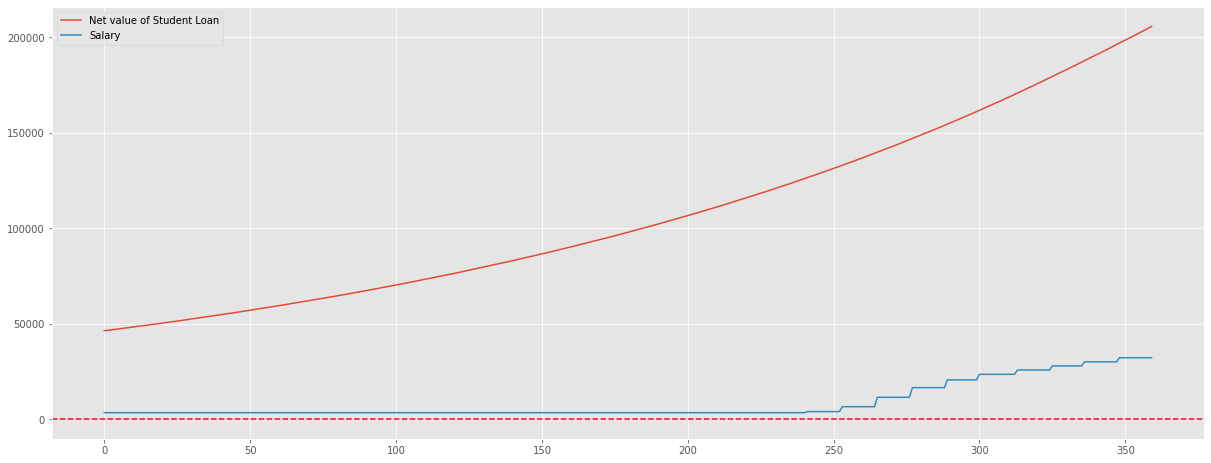

In [14]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y = 0, color = 'r', linestyle = '--')
sim, sal = simulateLifetimeEarnings(grossSalaryPA = male_HE['Earning'].min(),
                                    N = 30,
                                    principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                    employment_start = "2019-10-07", 
                                    method = "median")

ax.plot(sim, label = "Net value of Student Loan")
ax.plot(sal, label = "Salary")
plt.legend(loc="best");


As you can see in the plot above, the median male graduate's salary does not increase fast enough in the early years/over the 30 years to ever overcome the rate of compounding of the loan interest. Thus, the loan's net value spirals upwards, and they never pay it off. At 30 years, the loan will be cancelled. However, there are many confounding variables here - e.g. this is averaged across subjects and university (e.g. [Russell Group](https://russellgroup.ac.uk/about/) and nonRG), which both have very large variance in later life earnings. So this should be looked at purely as an example of the simulation.

# Enter Monte Carlo
Monte Carlo methods are a class of algorithms that rely on repeated random sampling to obtain numerical results - by the law of large numbers, the expected value of a random variable can be approximated by taking the sample mean of independent samples. 

In plain English: "while we don't know what the correct answer or strategy is, we can simulate thousands or millions of attempts and the average will approximate the right answer". Here is a [great example of Monte Carlo simulations](https://towardsdatascience.com/the-house-always-wins-monte-carlo-simulation-eb82787da2a3) showing how the House always wins - with Monte Carlo, we can simulate thousands of bets in a casino game, and when we average the simulation results, we can calculate the house edge, without knowing it to begin with. This has many other applications in anything that has a probabilistic element or has "risk", e.g. stock market and portfolio performance in Finance etc. 

## My model - Assumptions & Considerations
Since the amount of student finance I will pay across my working life is based on what I earn at time t, and I don't know what I will earn, I can simulate my career earnings using Monte Carlo. In my simulation:
* I have a starting salary for my first job
* I divide the 30 year payment period of the loan into different salary bands for my career
    * I chose 6 separate bands, each 5 years long (but this can be varied with ```salary_levels```)
    * Each salary band represents a salary increase - the increase is taken from a gaussian distribution centred around a mean which is a percentage of my gross salary
    * This percentage around which the distribution is centred decreases the further the simulation runs into my career
* I simulate my career according to these salary bands 1000000 times
* I calculate what the average salary trajectory would have allowed me to accomplish in terms of amortization

#### Translation: 
As a graduate earner, most salary growth occurs in the early years before levelling off. This means, on average, your percentage salary increase (either as an aggregation of several payrises, or one big jump due to moving job or a promotion) is larger earlier on and gets smaller later in life (relatively smaller but still a large payrise in absolute terms as it is a smaller percentage of an already large salary). In my simulation, this is represented by salary distributions which have a smaller "salary percentage increase" as their mean as it progresses through the salary bands. <br/><br/> However, a payrise of e.g. 30% in x years is not certain - it could be less simply because of the cards you were dealt, it could be less from a series of smaller payrises, or more a better offer, or series of larger payrises (the aggregate of which are represented in the 5-year jump. Overall, you could be less "lucky" (for lack of a better word) and have a series of smaller payrsises in your career or more luck and have a series of large payrises - much like a series of wins or losses in a casino. This is the great utility of Monte Carlo - I take my salary as a random variable from a normal distribution, meaning it could be less or more than the average. <br/><br/> For each of these x-year salary bands I can take 1000000 samples, resulting in 1000000 different salary trajectories for 30 years. I simulate all these trajectories and the monthly payments and see how many**

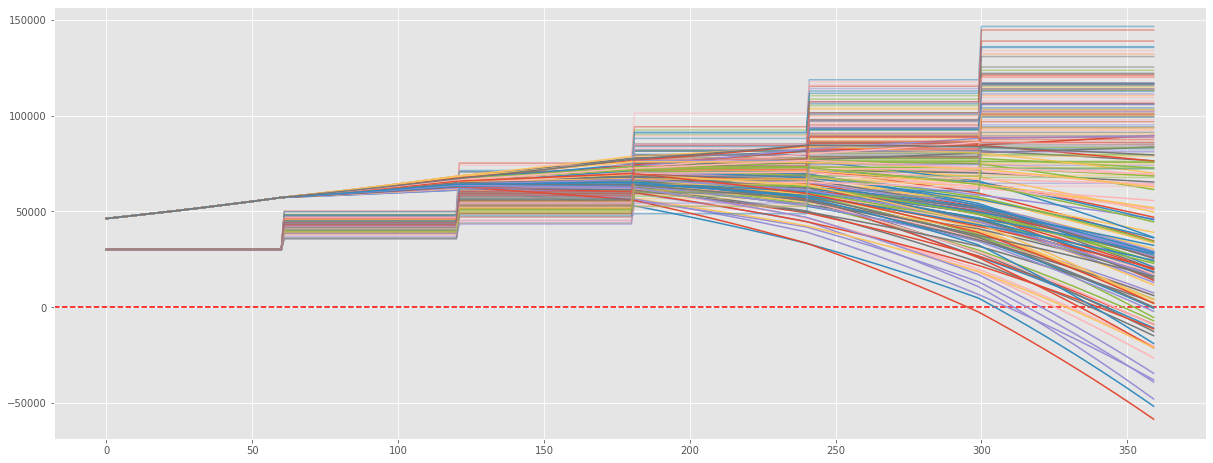

In [15]:
fig = plt.figure(figsize=(16,6))
ax = fig.add_axes([0,0,1,1])
plt.axhline(y = 0, color = 'r', linestyle = '--')
salary_levels = 6
np.random.seed(101)
startingSal = 30000
sims = 100
monte_carlo_increases = pd.DataFrame(np.row_stack([np.random.normal(loc=x, scale=0.1,size=(1,sims)) for x in np.linspace(.1,.4,salary_levels)[::-1]]))
paidOff = 0
monte_carlo_increases += 1
monte_carlo_increases.index += 1
for column in range(sims):
#     print(monte_carlo_increases[column])
    sim, sal = simulateLifetimeEarnings(grossSalaryPA = startingSal,
                                    N = 30,
                                    principal = graduateAmount(simEnd = "employment", employmentStart = "2019-10-07", myPayments = myPayments), 
                                    employment_start = "2019-10-07", 
                                    method = "monte carlo",
                                    increases = monte_carlo_increases[column])
    if sim[-1] < 0:
        paidOff += 1
    
    ax.plot(sal, label = "Salary", alpha = 0.5)
    ax.plot(sim, label = "Net value of Student Loan")
    
# plt.legend(loc="best");

## Results


## Evaluation - What should you do?!
From the simulation plot above, you can see that for the majority of projected earnings (the steps), the net value of the loan does not cross to below zero within the 30 year payment period. In fact, after x simulations of earnings trajectory, the average value of the loan after 30 years is _ . Having paid an avereage net total of _ towards the loan.

So what is the conclusion here? Should you voluntarily pay off .. purely practical etc